# Instacart grocery analysis

In this project, we will be analyzing an Instacart dataset which is anonymized and contains a sample of over 3 million grocery orders from more than 200,000 Instacart users.

Our goals for the analysis will be to identify trends related to customer ordering behavior as well as to determine which products, aisles, and departments are the most popular.

#### Some of our findings include:

- Customer ordering trends
    - Most orders are made between 9am and 4pm
    - The most common number of total orders across customers is 4
    - The most common number of products in an order is 5
    - 59% of all ordered products are reorders (were previously ordered by that customer)
    - The most common interval of time between an order and a reorder of that same product
        is either 1 week or 1 month


- The best selling departments (top 5)
    1. Produce
    2. Dairy & eggs
    3. Snacks
    4. Beverages
    5. Frozen
    
   
- The best selling aisles within each department (arbitrarily listing 5)
    - Bakery: bread
    - Alcohol: beer cooler
    - Beverages: tea
    - Canned goods: soup broth
    - Dairy & eggs: yogurt


- Aisles with the most products across all departments (top 5)
    1. Candy/chocolate
    2. Ice cream
    3. Vitamins/supplements
    4. Yogurt
    5. Chips
    

- The most ordered products (top 7)
    1. Bananas
    2. Strawberries
    3. Spinach
    4. Avocados
    5. Lemons
    6. Limes
    7. Milk
   

- The most reordered products (top 7)
    1. Serenity Overnight Pads
    2. Chocolate Love Bars
    3. Maca Buttercups
    4. Benchbreak Chardonnay
    5. Organic Blueberry B'Mega (drink)
    6. Fragrance Free Clay
    7. Thousand Island Salad Snax
 
 

#### We'll start off with our imports and file read-ins.

In [123]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.float_format', lambda x: '%.3f' % x)
from subprocess import check_output

print(check_output(["ls", "./instacart-files"]).decode("utf8"))

aisles.csv
departments.csv
order_products__prior.csv
order_products__train.csv
orders.csv
products.csv
sample_submission.csv



In [124]:
aisles = pd.read_csv('./instacart-files/aisles.csv')
departments = pd.read_csv('./instacart-files/departments.csv')
order_products_prior = pd.read_csv('./instacart-files/order_products__prior.csv')
order_products_train = pd.read_csv('./instacart-files/order_products__train.csv')
orders = pd.read_csv('./instacart-files/orders.csv')
products = pd.read_csv('./instacart-files/products.csv')

#### Next, we'll start taking a look at the shape and structure of our data before beginning our analysis, to see what we're working with.

In [125]:
print("The order_products_train size is : ", order_products_train.shape)
print("The order_products_prior size is : ", order_products_prior.shape)

The order_products_train size is :  (1384617, 4)
The order_products_prior size is :  (32434489, 4)


In [126]:
orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.000
2,473747,1,prior,3,3,12,21.000
3,2254736,1,prior,4,4,7,29.000
4,431534,1,prior,5,4,15,28.000


In [127]:
order_products_train.head()

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


In [128]:
order_products_prior.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [129]:
order_products_all = pd.concat([order_products_train, order_products_prior], axis=0)

print("The order_products_all size is : ", order_products_all.shape)

The order_products_all size is :  (33819106, 4)


In [130]:
order_products_all.head()

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


#### We'll see if there's any missing data in our order_products datasets.

In [144]:
total_missing = order_products_all.isnull().sum().sort_values(ascending=False)
percent_missing = (order_products_all.isnull().sum() / order_products_all.isnull().count()).sort_values(ascending=False)
missing_data_table = pd.concat([total_missing, percent_missing], axis=1, keys=['Total Missing', 'Percent Missing'])

missing_data_table

,Total Missing,Percent Missing
order_id,0,0.000
product_id,0,0.000
add_to_cart_order,0,0.000
reordered,0,0.000


#### So we see there is no missing data in our order_products_train and order_products_prior datasets.

In [132]:
orders_unique = len(set(order_products_all.order_id))
products_unique = len(set(order_products_all.product_id))

print("There are %s orders for %s products" %(orders_unique, products_unique))

There are 3346083 orders for 49685 products


#### We see there are over 3 million orders and almost 50,000 products.

#### Now, we'll explore the orders.csv file.

In [161]:
print("The orders data size is: ", orders.shape)
print("Columns in the orders data are: ", orders.columns.values)

The orders data size is:  (3421083, 7)
Columns in the orders data are:  ['order_id' 'user_id' 'eval_set' 'order_number' 'order_dow'
 'order_hour_of_day' 'days_since_prior_order']


In [162]:
orders.head(5)

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.000
2,473747,1,prior,3,3,12,21.000
3,2254736,1,prior,4,4,7,29.000
4,431534,1,prior,5,4,15,28.000


#### We'll look for missing data in our orders dataset

In [163]:
orders_na = (orders.isnull().sum() / len(orders)) * 100
orders_na = orders_na.drop(orders_na[orders_na == 0].index).sort_values(ascending=False)
orders_na

days_since_prior_order   6.028
dtype: float64

#### The only feature with missing values is days_since_prior_order, with 6.028% of its data missing.

# Total data

#### Total orders in the whole dataset

Now we'll see the total number of orders from the three datasets we have (prior, train, test),
as well as their distribution among the three datasets.

In [164]:
grouped = orders.groupby("eval_set")["order_id"].agg(Total_orders='count').reset_index()
grouped['Ratio'] = grouped["Total_orders"].apply(lambda x: x/grouped['Total_orders'].sum())
grouped

,eval_set,Total_orders,Ratio
0,prior,3214874,0.940
1,test,75000,0.022
2,train,131209,0.038


#### Total customers in the whole dataset

Now we'll look at the total number of unique customers in the three datasets (prior, train, test)

In [166]:
print("Number of unique customers in the whole dataset: ", len(set(orders.user_id)))

Number of unique customers in the whole dataset:  206209


In [175]:
print("Number of unique aisles: ", len(aisles['aisle'].unique()))

Number of unique aisles:  134


In [169]:
print("Number of unique products: ", len(products['product_id'].unique()))

Number of unique products:  49688


#### Now we'll explore data from the products, departments, and aisles files.

In [171]:
# display the first five rows of our dataset

products.head(5)

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [172]:
departments.head(5)

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


In [173]:
aisles.head(5)

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


#### We're done checking out our data, so now let's begin our analysis.

# Most ordered products

#### What I'm first curious about is which products are the most ordered.

In [134]:
grouped = order_products_all.groupby("product_id")["reordered"].agg(Total_reorders='count').reset_index()
grouped = pd.merge(grouped, products[['product_id', 'product_name']], how='left', on=['product_id'])
grouped = grouped.sort_values(by='Total_reorders', ascending=False)[:10]
grouped

,product_id,Total_reorders,product_name
24849,24852,491291,Banana
13173,13176,394930,Bag of Organic Bananas
21134,21137,275577,Organic Strawberries
21900,21903,251705,Organic Baby Spinach
47205,47209,220877,Organic Hass Avocado
47762,47766,184224,Organic Avocado
47622,47626,160792,Large Lemon
16794,16797,149445,Strawberries
26206,26209,146660,Limes
27842,27845,142813,Organic Whole Milk


#### Fruits and vegetables (such as bananas, strawberries, and spinach) seem to be the most ordered products. Let's see that same data in a bar graph.

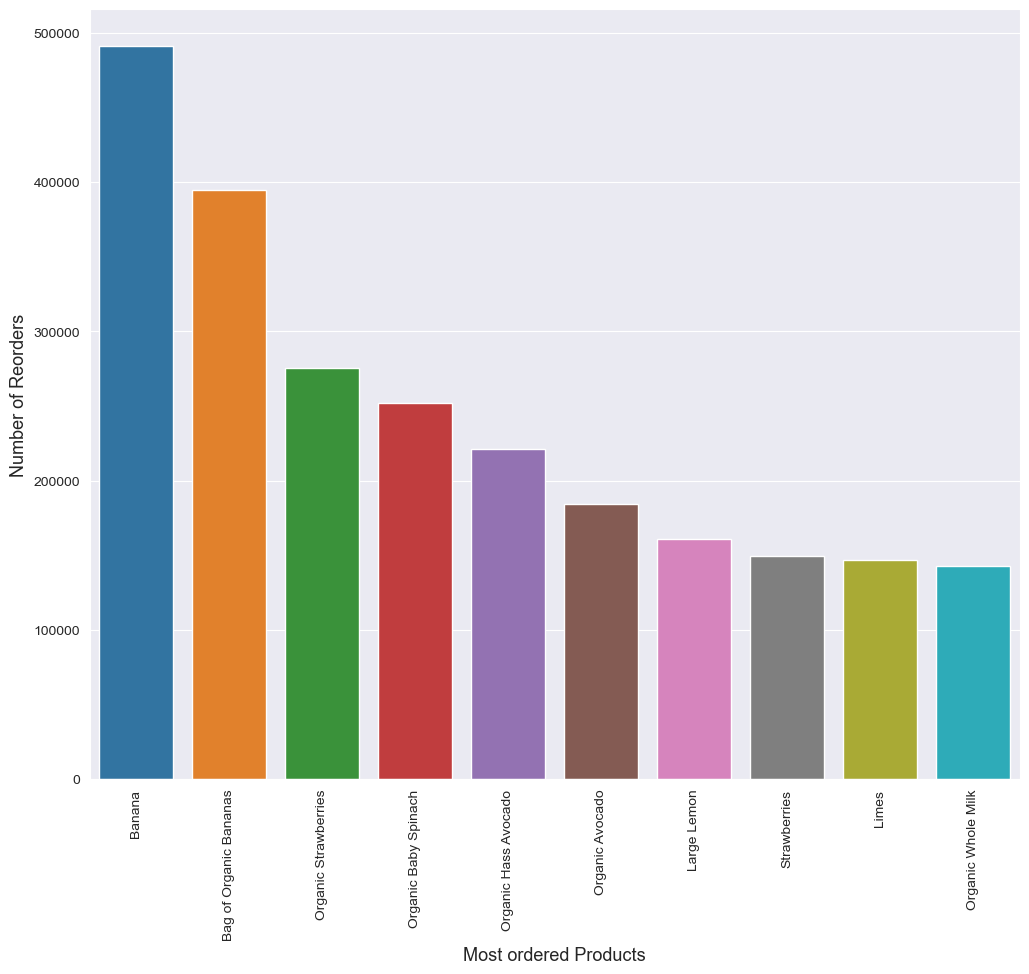

In [135]:
grouped = grouped.groupby(['product_name']).sum()['Total_reorders'].sort_values(ascending=False)

sns.set_style('darkgrid')
f, ax = plt.subplots(figsize=(12, 10))
plt.xticks(rotation='vertical')
sns.barplot(grouped.index, grouped.values)
plt.ylabel('Number of Reorders', fontsize=13)
plt.xlabel('Most ordered Products', fontsize=13)
plt.show()

# Number of products that users commonly order

#### Next, I'm curious to see how many products there are in a typical order.

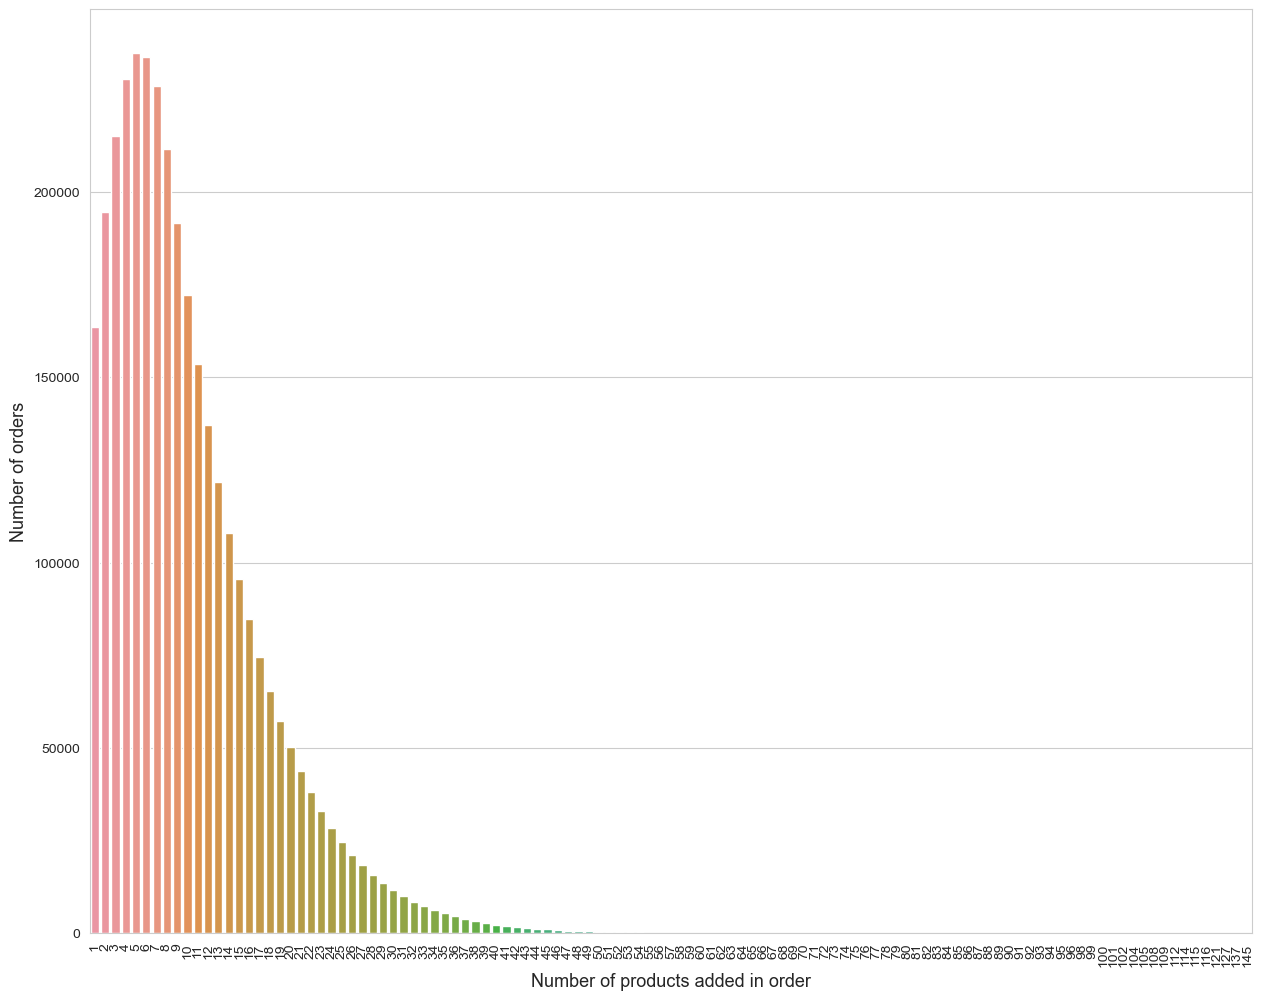

In [178]:
grouped = order_products_all.groupby("order_id")["add_to_cart_order"].aggregate("max").reset_index()
grouped = grouped.add_to_cart_order.value_counts()

sns.set_style('whitegrid')
f, ax = plt.subplots(figsize=(15, 12))
plt.xticks(rotation='vertical')
sns.barplot(grouped.index, grouped.values)

plt.ylabel('Number of orders', fontsize=13)
plt.xlabel('Number of products added in order', fontsize=13)
plt.show()

#### We see that the most common number of products in an order is about 5.

# Reorder frequency

#### Do users usually reorder the same products that they previously ordered?

In [137]:
grouped = order_products_all.groupby("reordered")["product_id"].agg(Total_products='count').reset_index()
grouped['Ratios'] = grouped["Total_products"].apply(lambda x: x/grouped['Total_products'].sum())
grouped

,reordered,Total_products,Ratios
0,0,13863746,0.410
1,1,19955360,0.590


#### 59% of all ordered products were previously ordered by customers.

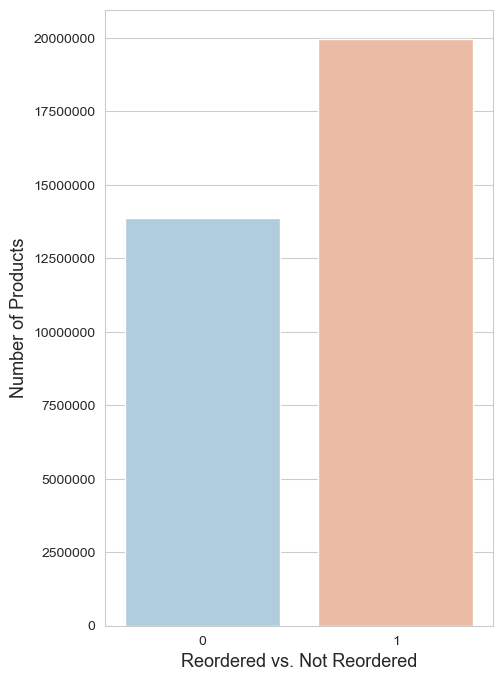

In [138]:
grouped = grouped.groupby(['reordered']).sum()['Total_products'].sort_values(ascending=False)

sns.set_style('whitegrid')
f, ax = plt.subplots(figsize=(5, 8))
sns.barplot(grouped.index, grouped.values, palette='RdBu_r')
plt.ylabel('Number of Products', fontsize=13)
plt.xlabel('Reordered vs. Not Reordered', fontsize=13)
plt.ticklabel_format(style='plain', axis='y')
plt.show()

# Most Reordered Products

#### Which products are most commonly reordered?

In [59]:
grouped = order_products_all.groupby("product_id")["reordered"].agg(reorder_sum=sum, reorder_total='count').reset_index()

grouped['reorder_probability'] = grouped['reorder_sum'] / grouped['reorder_total']
grouped = pd.merge(grouped, products[['product_id', 'product_name']], how='left', on=['product_id'])
grouped = grouped[grouped.reorder_total > 75].sort_values(['reorder_probability'], ascending=False)[:10]
grouped


,product_id,reorder_sum,reorder_total,reorder_probability,product_name
2074,2075,84,90,0.933,Serenity Ultimate Extrema Overnight Pads
27737,27740,94,102,0.922,Chocolate Love Bar
35601,35604,93,104,0.894,Maca Buttercups
38248,38251,99,111,0.892,Benchbreak Chardonnay
36798,36801,88,99,0.889,Organic Blueberry B Mega
10233,10236,114,131,0.870,Fragrance Free Clay with Natural Odor Eliminat...
20595,20598,99,114,0.868,Thousand Island Salad Snax
5455,5457,78,90,0.867,Classic Carbonated Natural Mineral Water
35493,35496,394,457,0.862,Real2 Alkalized Water 500 ml
9289,9292,2580,2995,0.861,Half And Half Ultra Pasteurized


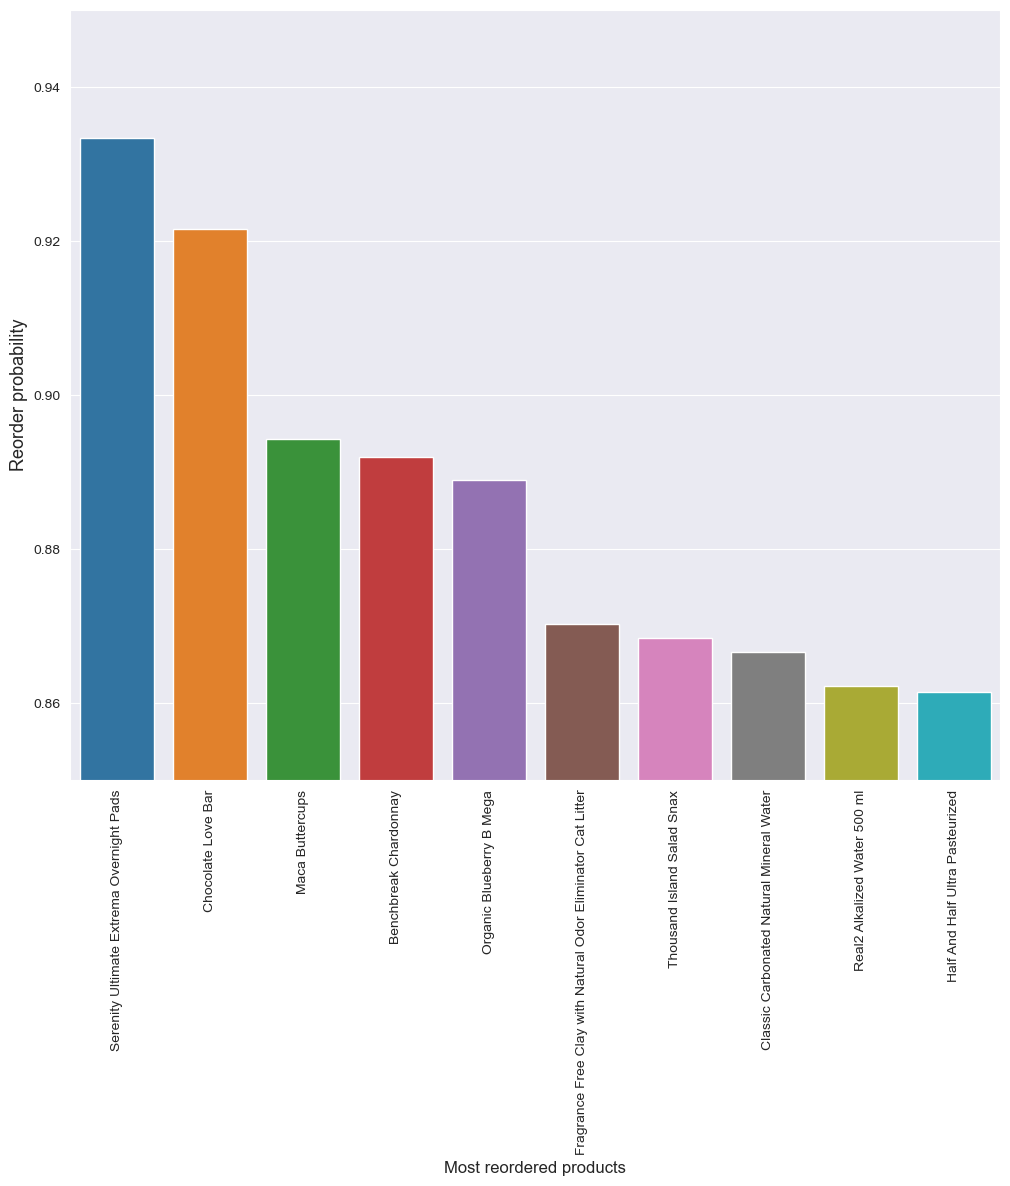

In [60]:
grouped = grouped.groupby(['product_name']).sum()['reorder_probability'].sort_values(ascending=False)

sns.set_style('darkgrid')
f, ax = plt.subplots(figsize=(12, 10))
plt.xticks(rotation='vertical')
sns.barplot(grouped.index, grouped.values)
plt.ylim(0.85, 0.95)
plt.ylabel('Reorder probability', fontsize=13)
plt.xlabel('Most reordered products', fontsize=12)
plt.show()

# Period of time before a reorder

#### Now we'll see how long Instacart users typically wait before reordering a product.

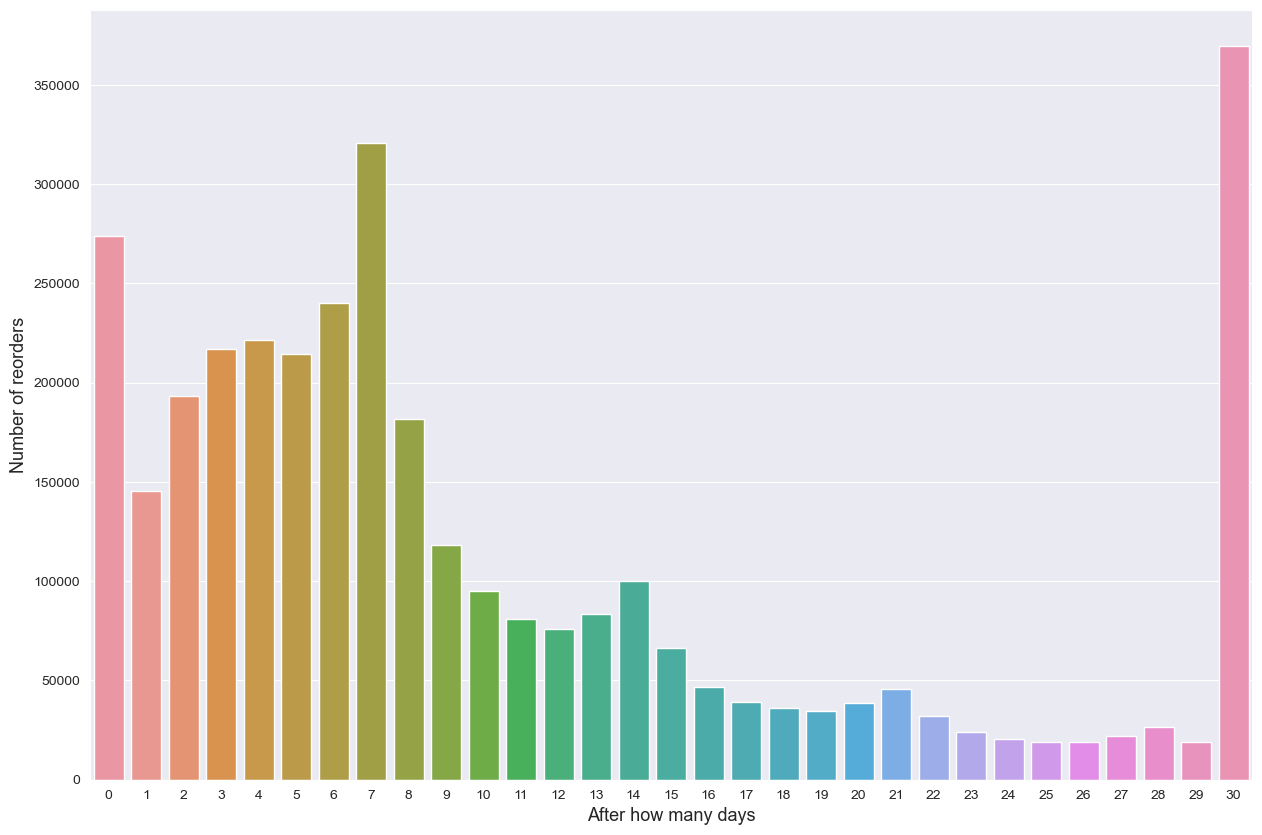

In [70]:
grouped = orders.groupby("order_id")["days_since_prior_order"].agg("sum").reset_index()
grouped = grouped.days_since_prior_order.value_counts()

from matplotlib.ticker import FormatStrFormatter
f, ax = plt.subplots(figsize=(15, 10))
sns.barplot(grouped.index, grouped.values)
ax.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
plt.ylabel('Number of reorders', fontsize=13)
plt.xlabel('After how many days', fontsize=13)
plt.show()

#### We see that the two most common lengths of time that users wait before reordering a product is 1 week and 1 month.

# Orders made by each customer

#### Now we'll look at the number of orders made by each customer in the entire dataset.

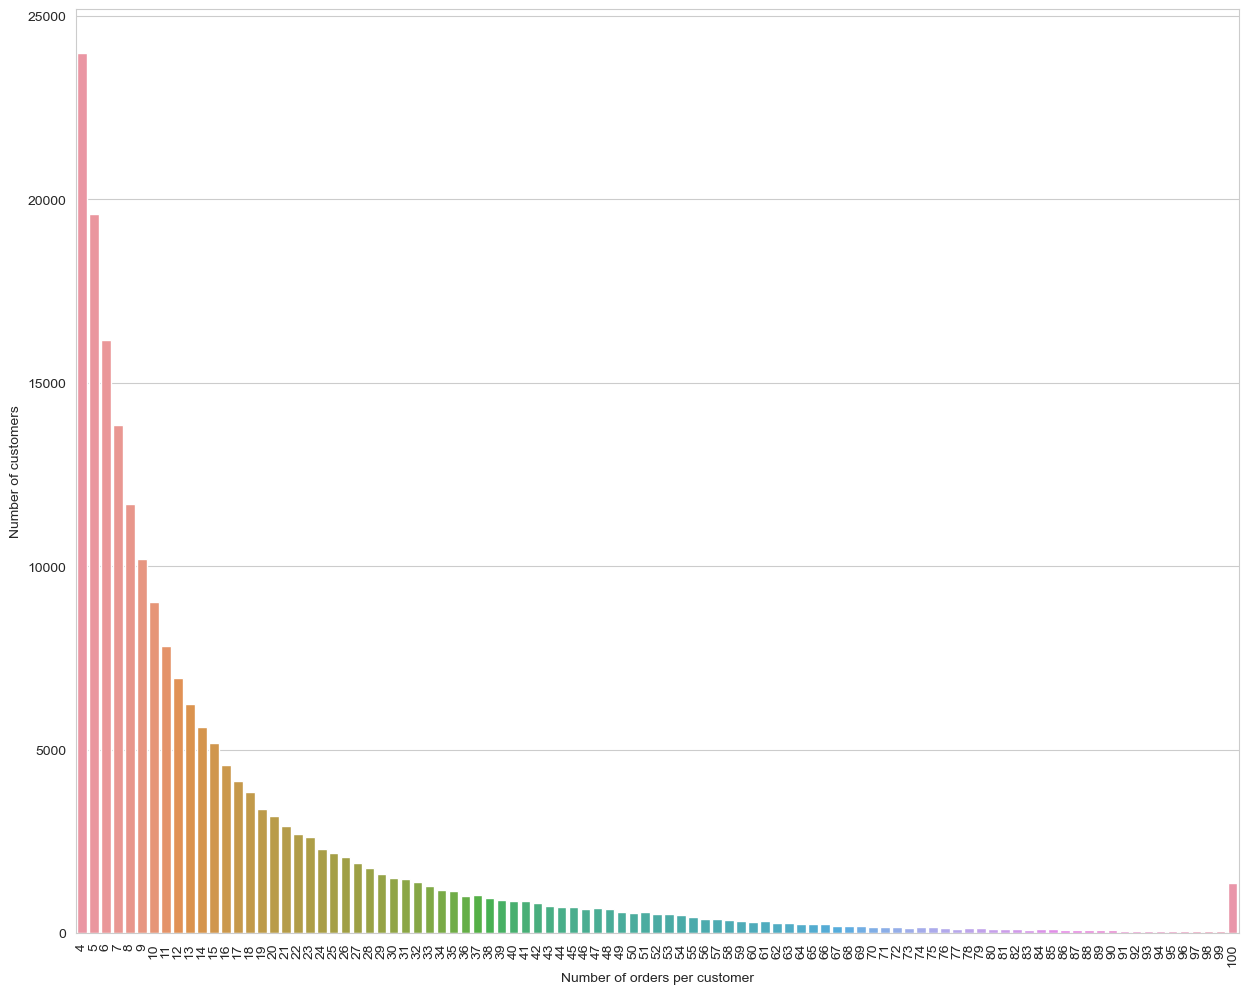

In [75]:
grouped = orders.groupby('user_id')['order_id'].apply(lambda x: len(x.unique())).reset_index()
grouped = grouped.groupby('order_id').aggregate('count')

sns.set_style("whitegrid")
f, ax = plt.subplots(figsize=(15,12))
sns.barplot(grouped.index, grouped.user_id)
plt.ylabel('Number of customers')
plt.xlabel('Number of orders per customer')
plt.xticks(rotation='vertical')
plt.show()

#### We see that the most common number of orders among all customers was 4. (In fact, we see that the minimum is 4... This was interesting to me. It may have to do with Instacart possibly running a promotion, such as one I found on Google which gives the user free deliveries for their first 3 orders)

# Time and day of orders

#### Now we'll explore which time of day that users most often order products.

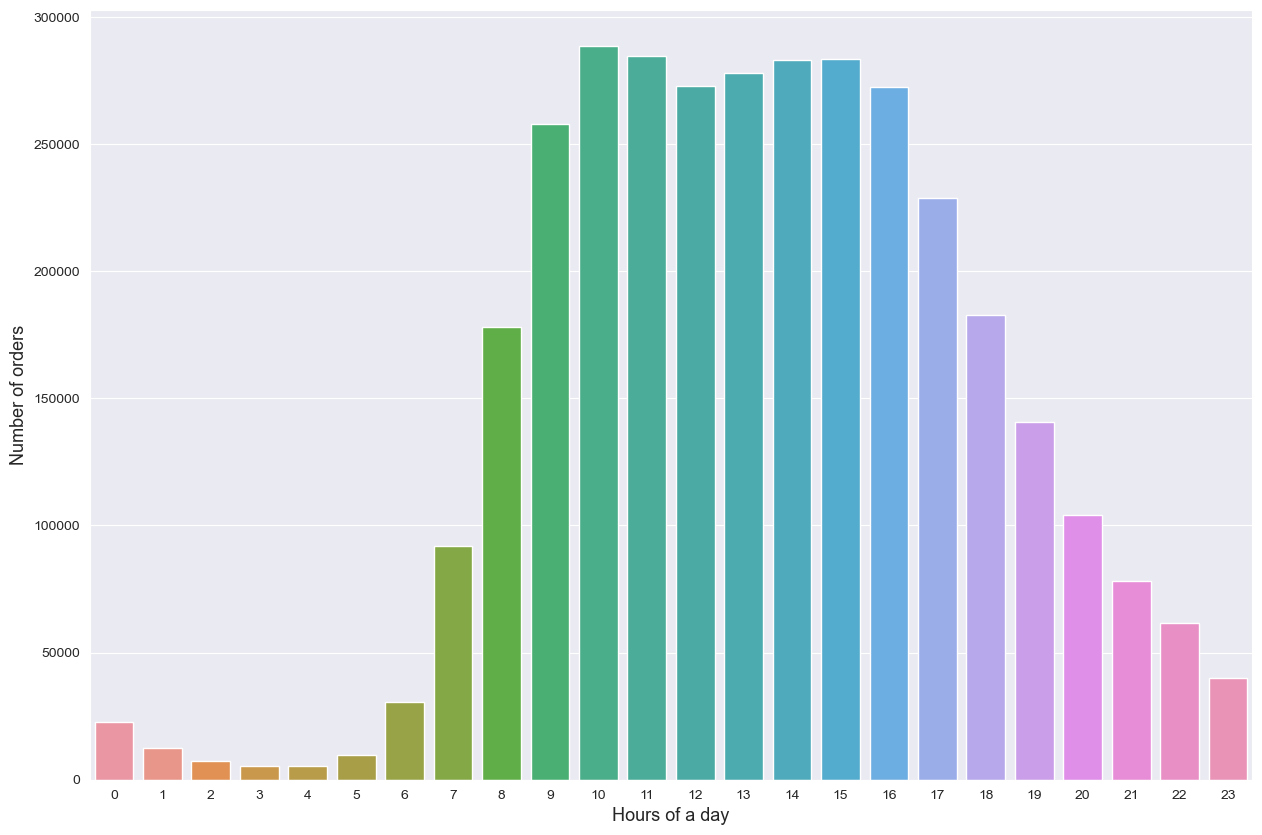

In [176]:
grouped = orders.groupby("order_id")["order_hour_of_day"].agg('sum').reset_index()
grouped = grouped.order_hour_of_day.value_counts()

sns.set_style('darkgrid')
f, ax = plt.subplots(figsize=(15, 10))
sns.barplot(grouped.index, grouped.values)
plt.ylabel('Number of orders', fontsize=13)
plt.xlabel('Hours of a day', fontsize=13)
plt.show()

#### So we see here that most users order between 9 a.m. and 4 p.m.


#### Now we'll look at which days of the week get the most orders.

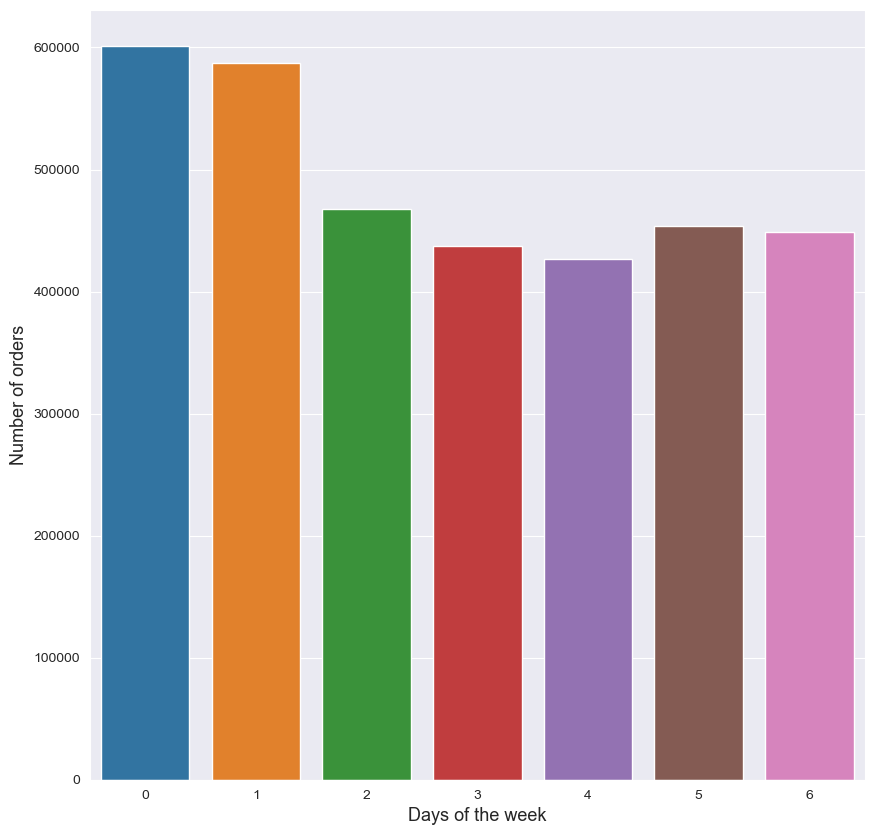

In [177]:
grouped = orders.groupby("order_id")["order_dow"].agg("sum").reset_index()
grouped = grouped.order_dow.value_counts()

f, ax = plt.subplots(figsize=(10, 10))
sns.barplot(grouped.index, grouped.values)
plt.ylabel('Number of orders', fontsize=13)
plt.xlabel('Days of the week', fontsize=13)
plt.show()

#### So we see that users most often order on days 0 and 1 (the days are actually anonymized, so we don't know for sure what these day-numbers correspond to, but it's likely that 0 and 1 are Saturday and Sunday)

# Most important departments (by number of products)

#### For our next part of the analysis, we'll combine three of our datasets (products, departments, and aisles) into a single Pandas dataframe.

In [174]:
items = pd.merge(left=pd.merge(left=products, right=departments, how='left'), right =aisles, how='left')
items.head(5)

,product_id,product_name,aisle_id,department_id,department,aisle
0,1,Chocolate Sandwich Cookies,61,19,snacks,cookies cakes
1,2,All-Seasons Salt,104,13,pantry,spices seasonings
2,3,Robust Golden Unsweetened Oolong Tea,94,7,beverages,tea
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1,frozen,frozen meals
4,5,Green Chile Anytime Sauce,5,13,pantry,marinades meat preparation


In [85]:
grouped = items.groupby("department")["product_id"].agg(Total_products='count').reset_index()
grouped['Ratio'] = grouped["Total_products"].apply(lambda x: x/grouped['Total_products'].sum())
grouped.sort_values(by='Total_products', ascending=False, inplace=True)
grouped

,department,Total_products,Ratio
17,personal care,6563,0.132
20,snacks,6264,0.126
16,pantry,5371,0.108
3,beverages,4365,0.088
10,frozen,4007,0.081
7,dairy eggs,3449,0.069
11,household,3085,0.062
6,canned goods,2092,0.042
9,dry goods pasta,1858,0.037
19,produce,1684,0.034


#### Now let's display this table as a bar graph.

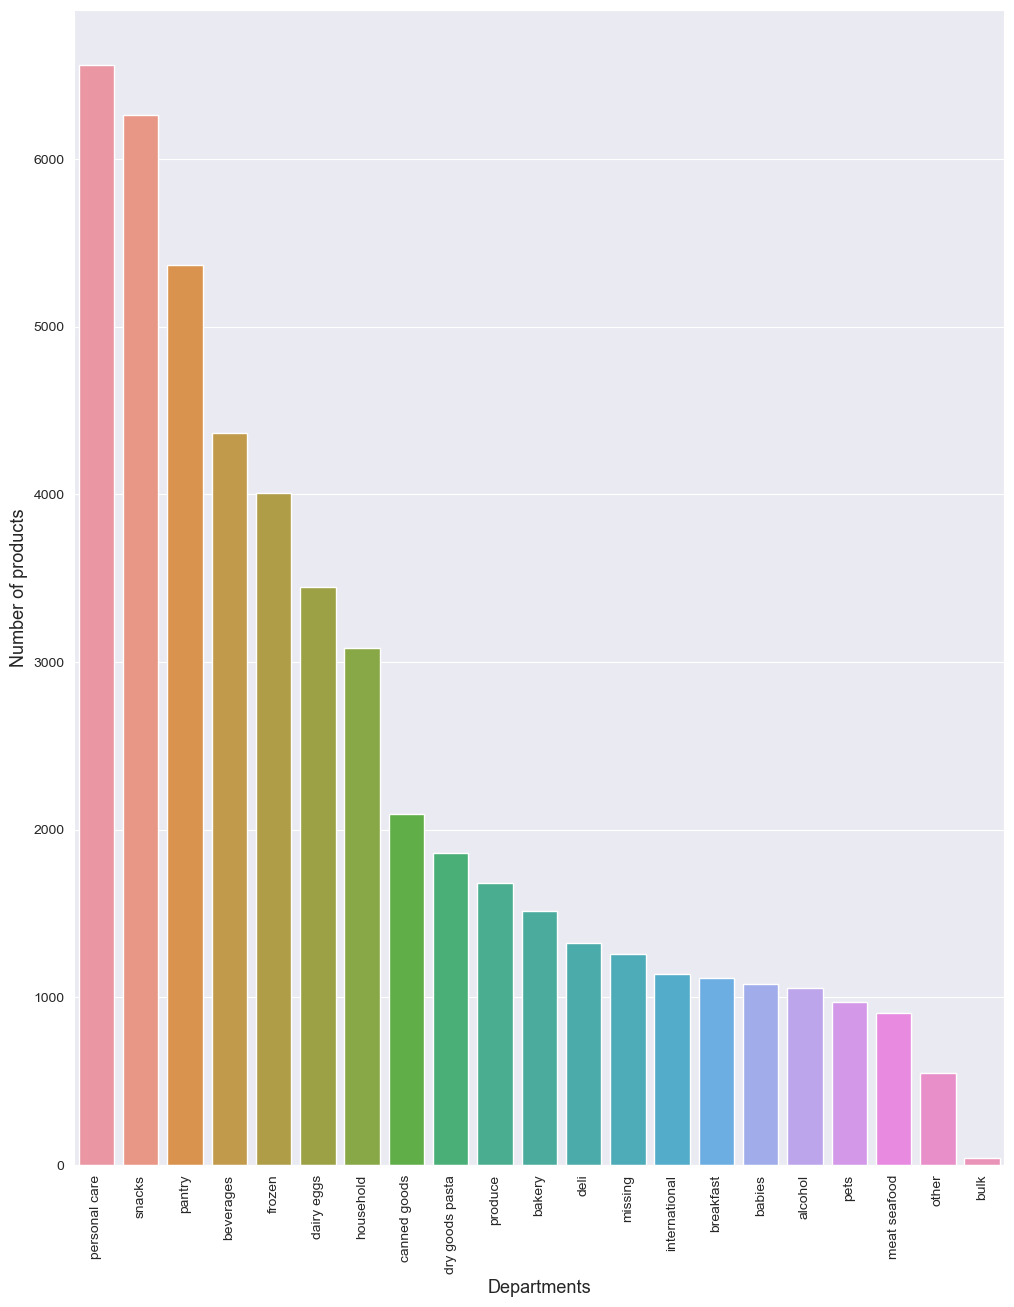

In [86]:
grouped = grouped.groupby(['department']).sum()['Total_products'].sort_values(ascending=False)

sns.set_style("darkgrid")
f, ax = plt.subplots(figsize=(12,15))
plt.xticks(rotation='vertical')
sns.barplot(grouped.index, grouped.values)
plt.ylabel('Number of products', fontsize=13)
plt.xlabel('Departments', fontsize=13)
plt.show()

#### We see that personal care and snacks are the most important departments (in terms of number of products), with pets and meat seafood being among the least important.

# Most important aisles in each department (by number of products)

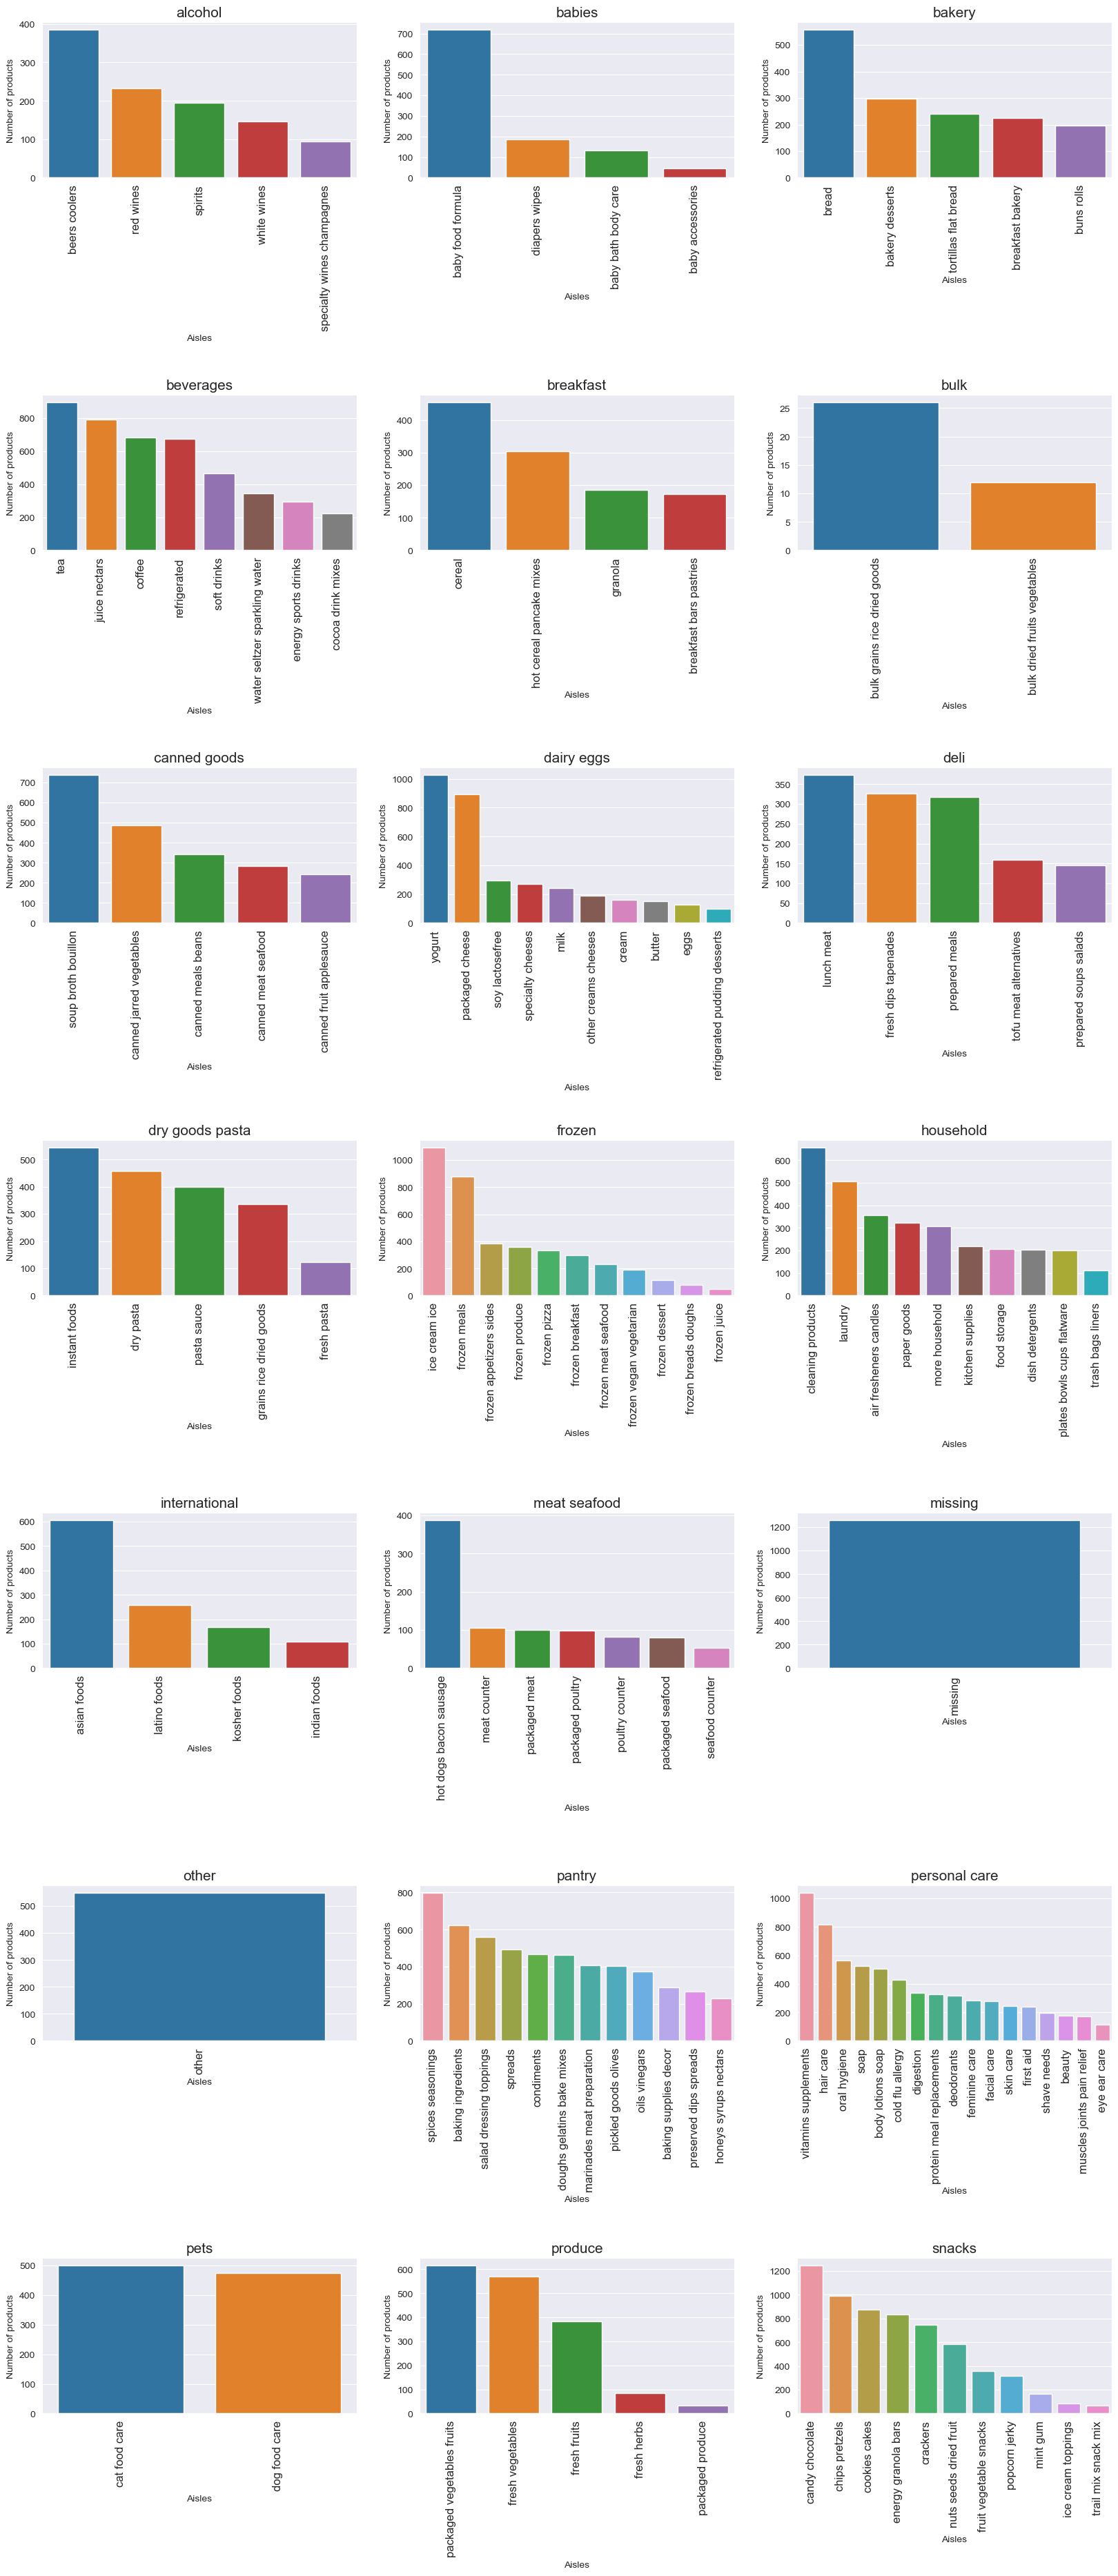

In [99]:
grouped = items.groupby(["department", "aisle"])["product_id"].agg(Total_products='count').reset_index()
grouped.sort_values(by='Total_products', ascending=False, inplace=True)

fig, axes = plt.subplots(7, 3, figsize=(20, 45), gridspec_kw = dict(hspace=1.4))
# fig, axes = plt.subplots(7, 3, figsize=(20, 45))

for (aisle, group), ax in zip(grouped.groupby(["department"]), axes.flatten()):
    graph = sns.barplot(group.aisle, group.Total_products, ax=ax)
    ax.set(xlabel = "Aisles", ylabel = "Number of products")
    graph.set_xticklabels(labels=group.aisle, rotation=90, fontsize=12)
    ax.set_title(aisle, fontsize=15)
    

# Most important aisles across all departments (by number of products)

In [100]:
grouped = items.groupby("aisle")["product_id"].agg(Total_products='count').reset_index()
grouped['Ratio'] = grouped["Total_products"].apply(lambda x: x/grouped['Total_products'].sum())
grouped = grouped.sort_values(by='Total_products', ascending=False)[:20]
grouped

,aisle,Total_products,Ratio
85,missing,1258,0.025
18,candy chocolate,1246,0.025
71,ice cream ice,1091,0.022
130,vitamins supplements,1038,0.021
133,yogurt,1026,0.021
25,chips pretzels,989,0.020
125,tea,894,0.018
93,packaged cheese,891,0.018
59,frozen meals,880,0.018
31,cookies cakes,874,0.018


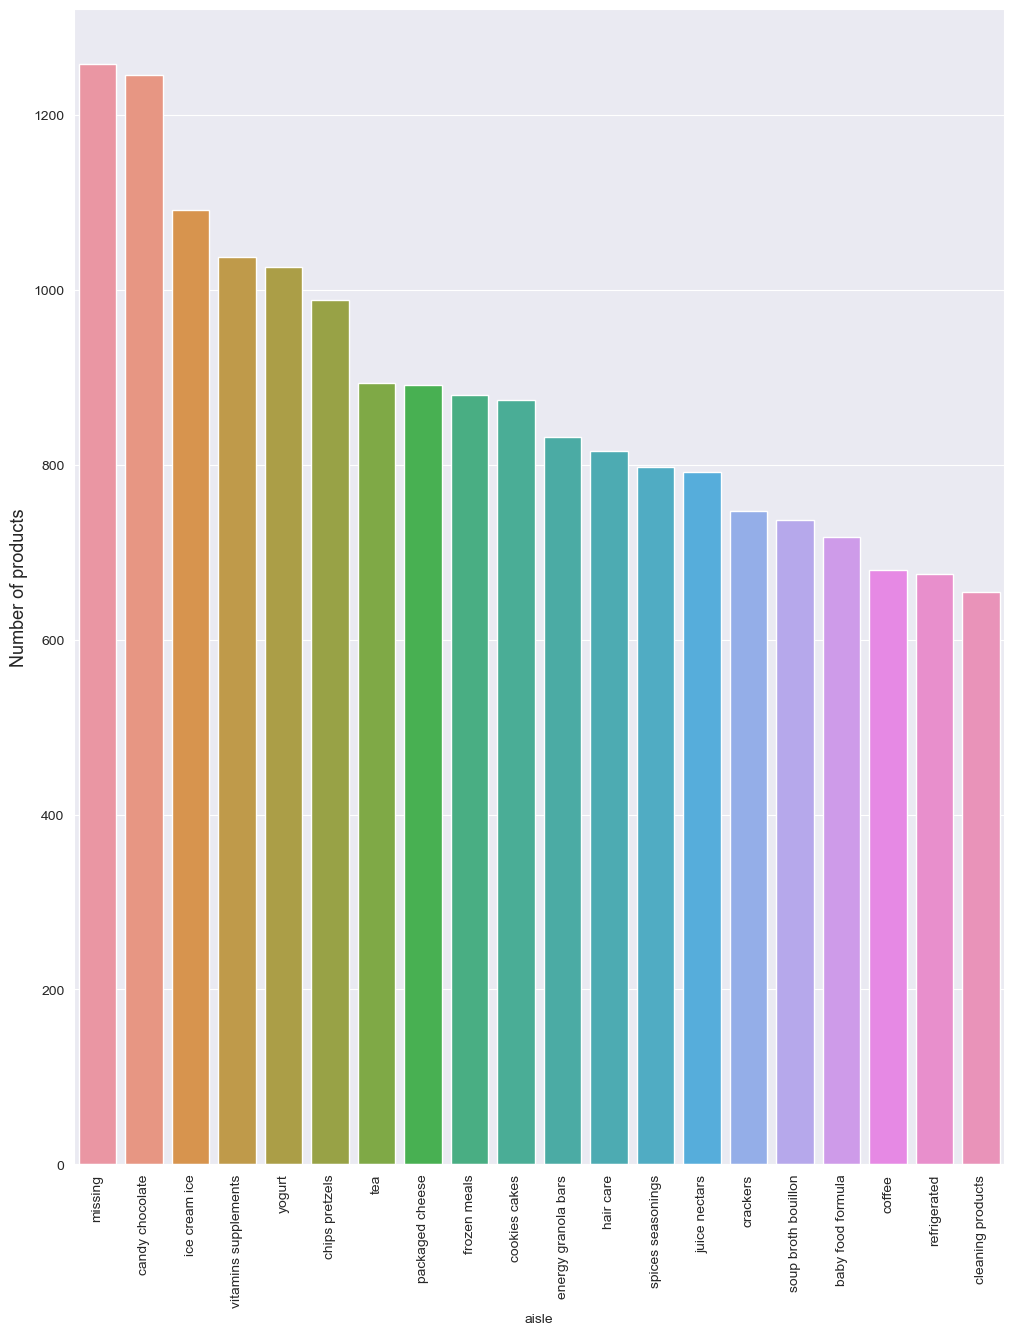

In [101]:
grouped = grouped.groupby(['aisle']).sum()['Total_products'].sort_values(ascending=False)

f, ax = plt.subplots(figsize=(12,15))
plt.xticks(rotation='vertical')
sns.barplot(grouped.index, grouped.values)
plt.ylabel('Number of products', fontsize=13)
plt.show()

# What are customers' favorite departments and aisles?

In [154]:
users_flow = orders[['user_id', 'order_id']].merge(order_products_train[['order_id', 'product_id']],
                                                  how='inner', left_on='order_id', right_on='order_id')
users_flow = users_flow.merge(items, how='inner', left_on='product_id', right_on='product_id')

# users_flow.head(15)
# users_flow.groupby("aisle_id").first()
users_flow.drop_duplicates(subset=['department_id'])

,user_id,order_id,product_id,product_name,aisle_id,department_id,department,aisle
0,1,1187899,196,Soda,77,7,beverages,soft drinks
1507,1,1187899,25133,Organic String Cheese,21,16,dairy eggs,packaged cheese
2106,1,1187899,26405,XL Pick-A-Size Paper Towel Rolls,54,17,household,paper goods
2211,1,1187899,39657,Milk Chocolate Almonds,45,19,snacks,candy chocolate
2574,1,1187899,13032,Cinnamon Toast Crunch,121,14,breakfast,cereal
...,...,...,...,...,...,...,...,...
150640,34,698604,38273,Marinara Pasta Sauce,9,9,dry goods pasta,pasta sauce
219994,49,519514,18118,MixUps Backyard Cookout Cat Treats,41,8,pets,cat food care
252293,59,1651215,47888,Apple and Carrot Stage 2 Baby Food,92,18,babies,baby food formula
280679,64,2639013,5161,Dried Mango,18,10,bulk,bulk dried fruits vegetables


# Best selling departments (by number of orders)

In [112]:
grouped = users_flow.groupby("department")["order_id"].agg(Total_orders='count').reset_index()
grouped['Ratio'] = grouped["Total_orders"].apply(lambda x: x/grouped['Total_orders'].sum())
grouped.sort_values(by='Total_orders', ascending=False, inplace=True)
grouped

,department,Total_orders,Ratio
19,produce,409087,0.295
7,dairy eggs,217051,0.157
20,snacks,118862,0.086
3,beverages,114046,0.082
10,frozen,100426,0.073
...,...,...,...
14,missing,8251,0.006
0,alcohol,5598,0.004
18,pets,4497,0.003
15,other,1795,0.001


#### Let's display this table as a bar graph.

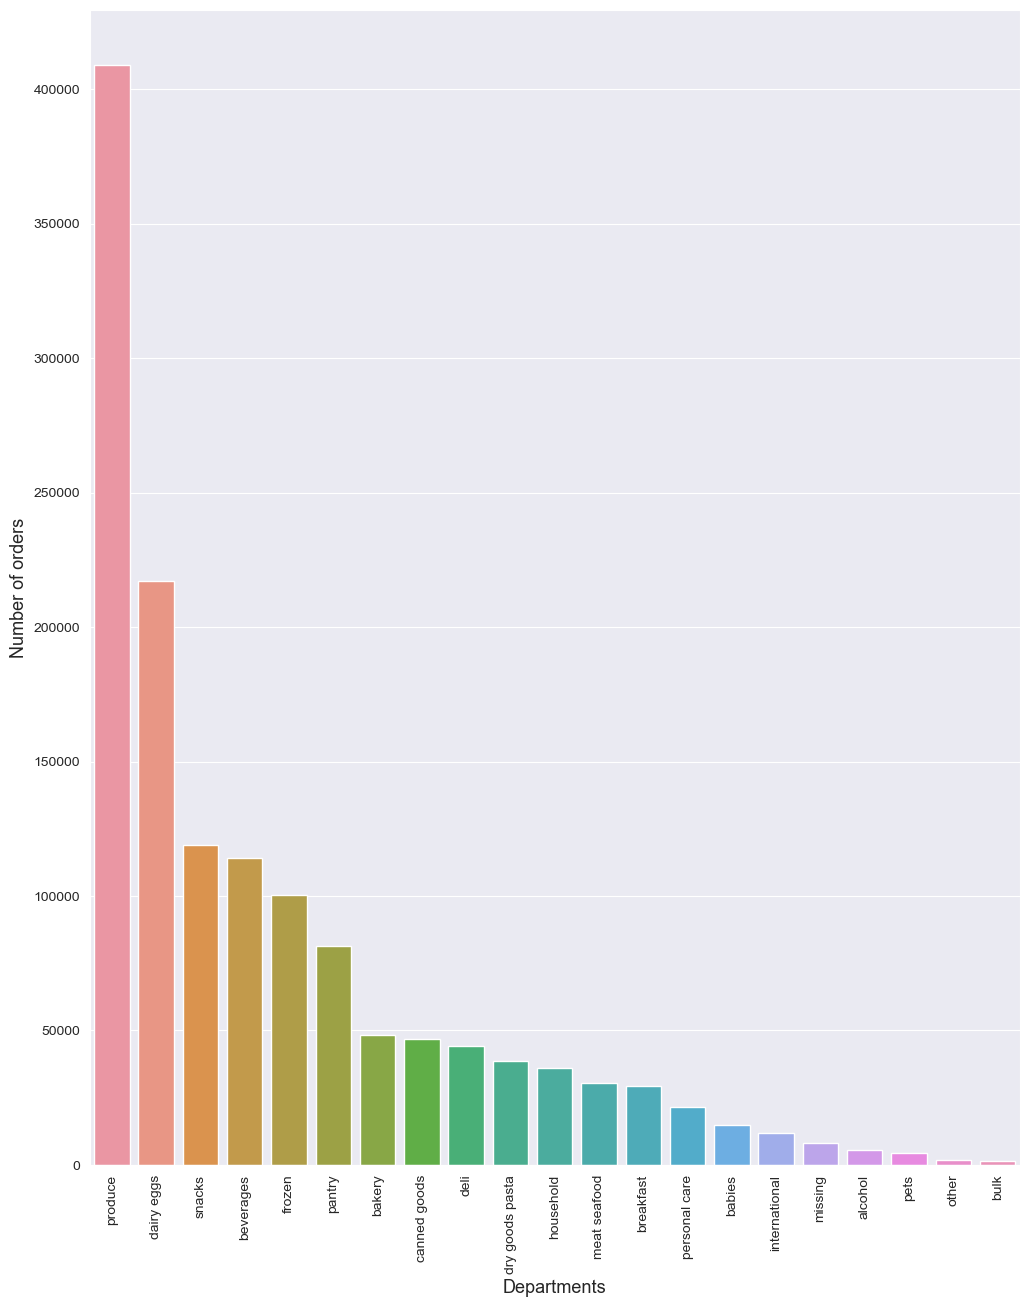

In [113]:
grouped = grouped.groupby(['department']).sum()['Total_orders'].sort_values(ascending=False)

f, ax = plt.subplots(figsize=(12,15))
plt.xticks(rotation='vertical')
sns.barplot(grouped.index, grouped.values)
plt.ylabel('Number of orders', fontsize=13)
plt.xlabel('Departments',fontsize=13)
plt.show()

# Best selling aisles in each department (by number of orders)

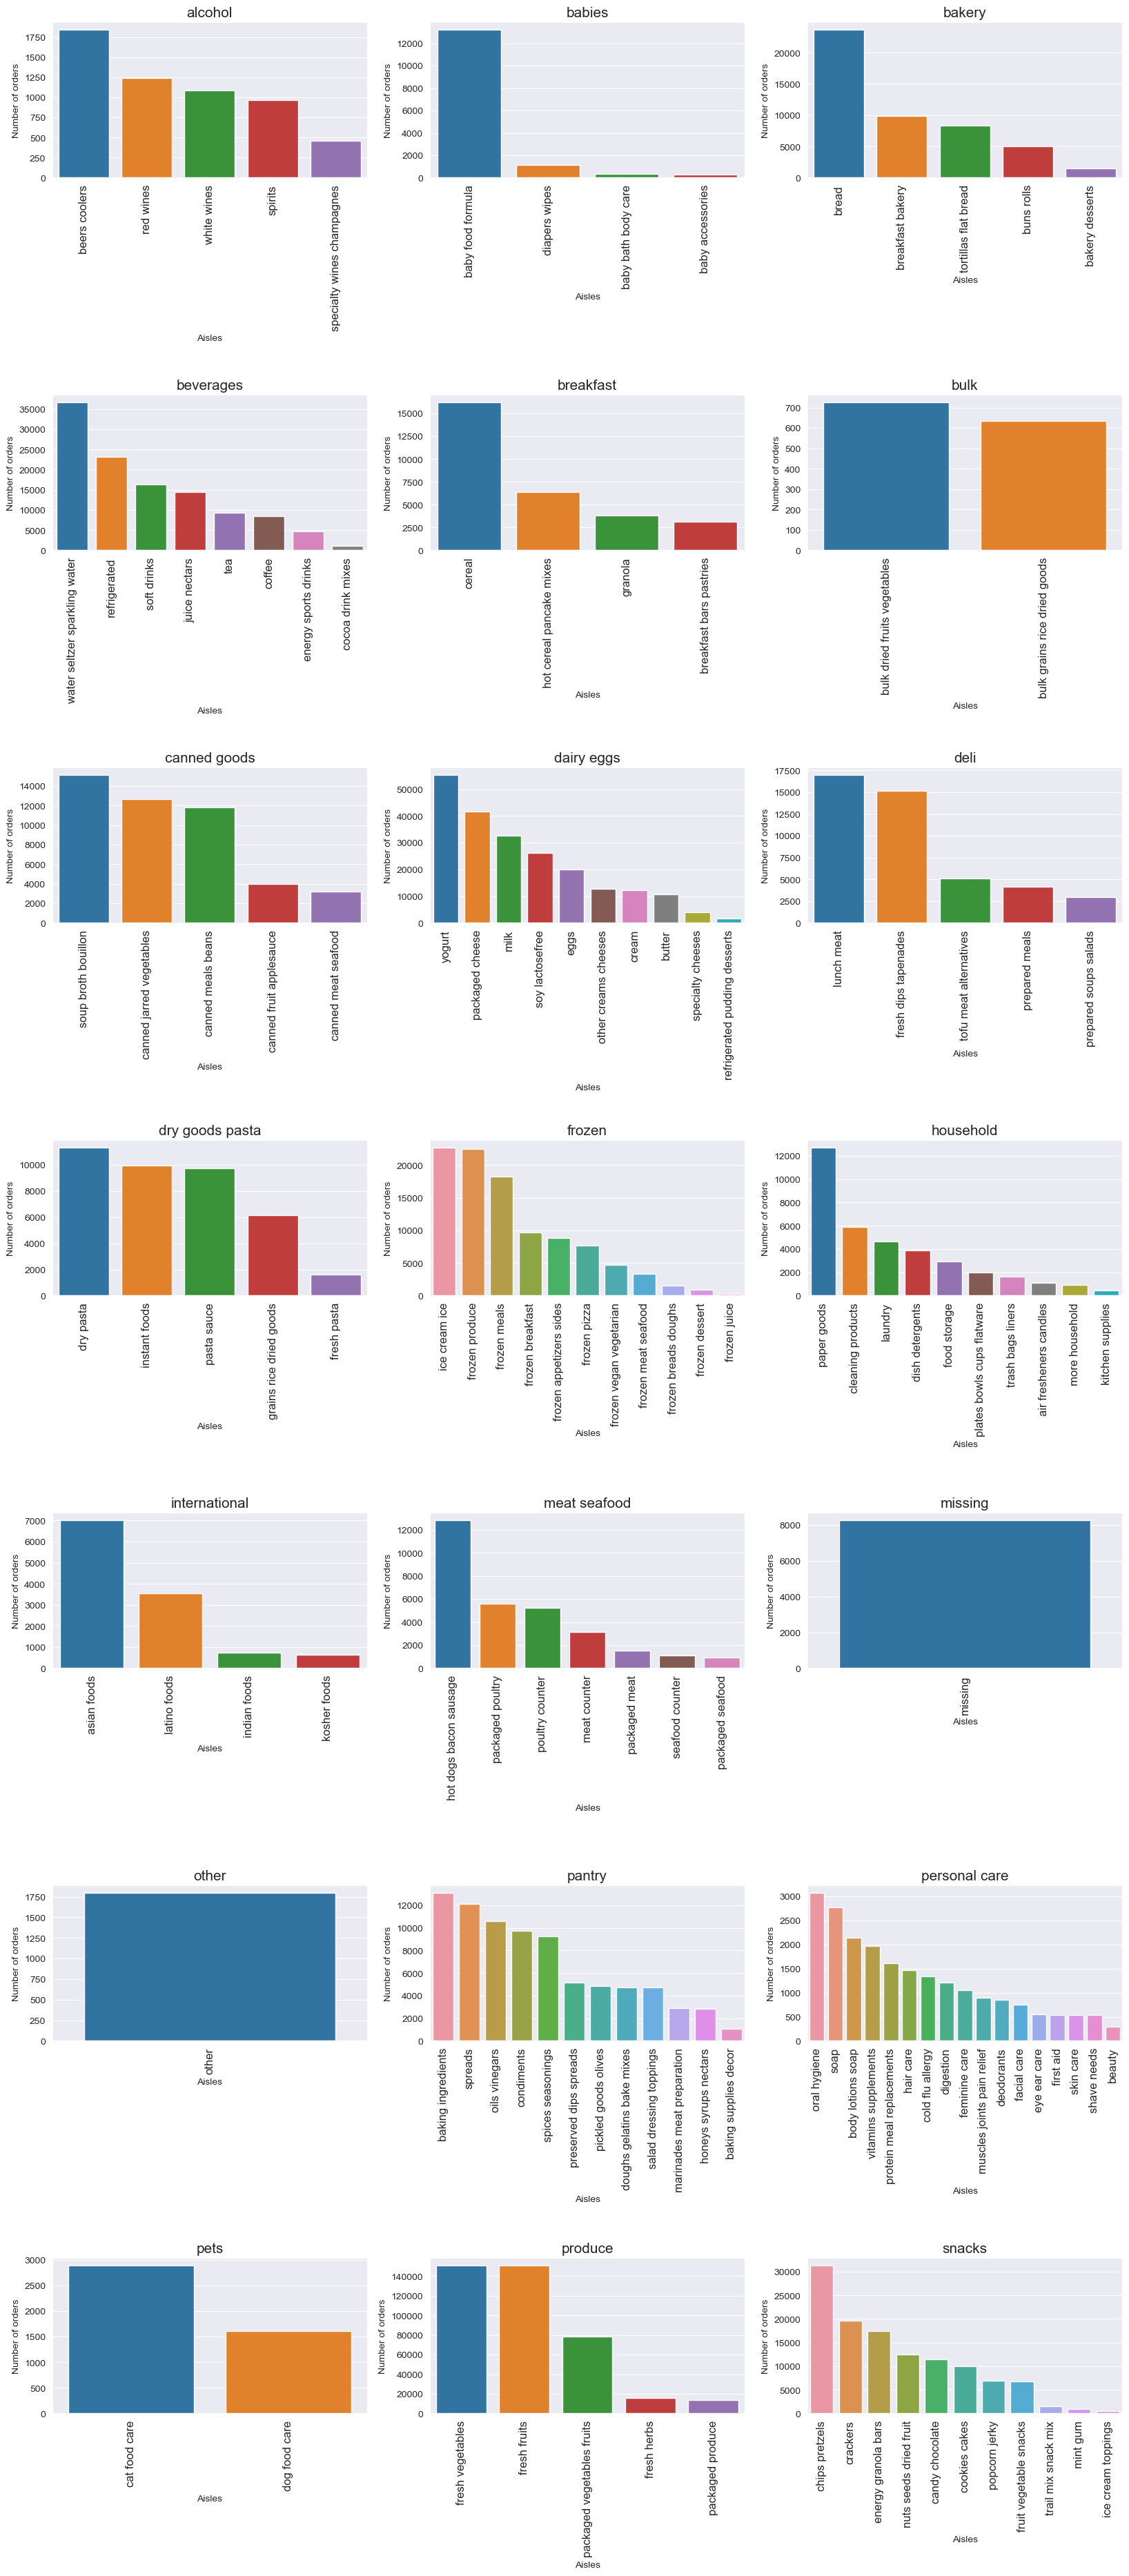

In [115]:
grouped = users_flow.groupby(["department", "aisle"])["order_id"].agg(Total_orders='count').reset_index()
grouped.sort_values(by='Total_orders', ascending=False, inplace=True)

fig, axes = plt.subplots(7, 3, figsize=(20,45), gridspec_kw = dict(hspace=1.4))
for (aisle, group), ax in zip(grouped.groupby(["department"]), axes.flatten()):
    graph = sns.barplot(group.aisle, group.Total_orders, ax=ax)
    ax.set(xlabel = 'Aisles', ylabel = 'Number of orders')
    graph.set_xticklabels(labels = group.aisle, rotation=90, fontsize=12)
    ax.set_title(aisle, fontsize=15)


# Best selling aisles across all departments

In [118]:
grouped = users_flow.groupby("aisle")["order_id"].agg(Total_orders='count').reset_index()
grouped['Ratio'] = grouped['Total_orders'].apply(lambda x: x/grouped['Total_orders'].sum())
grouped.sort_values(by='Total_orders', ascending=False, inplace=True)
grouped.head(10)

,aisle,Total_orders,Ratio
53,fresh vegetables,150609,0.109
50,fresh fruits,150473,0.109
98,packaged vegetables fruits,78493,0.057
133,yogurt,55240,0.040
93,packaged cheese,41699,0.030
131,water seltzer sparkling water,36617,0.026
83,milk,32644,0.024
25,chips pretzels,31269,0.023
119,soy lactosefree,26240,0.019
11,bread,23635,0.017


#### We'll again put this table into a bar chart.

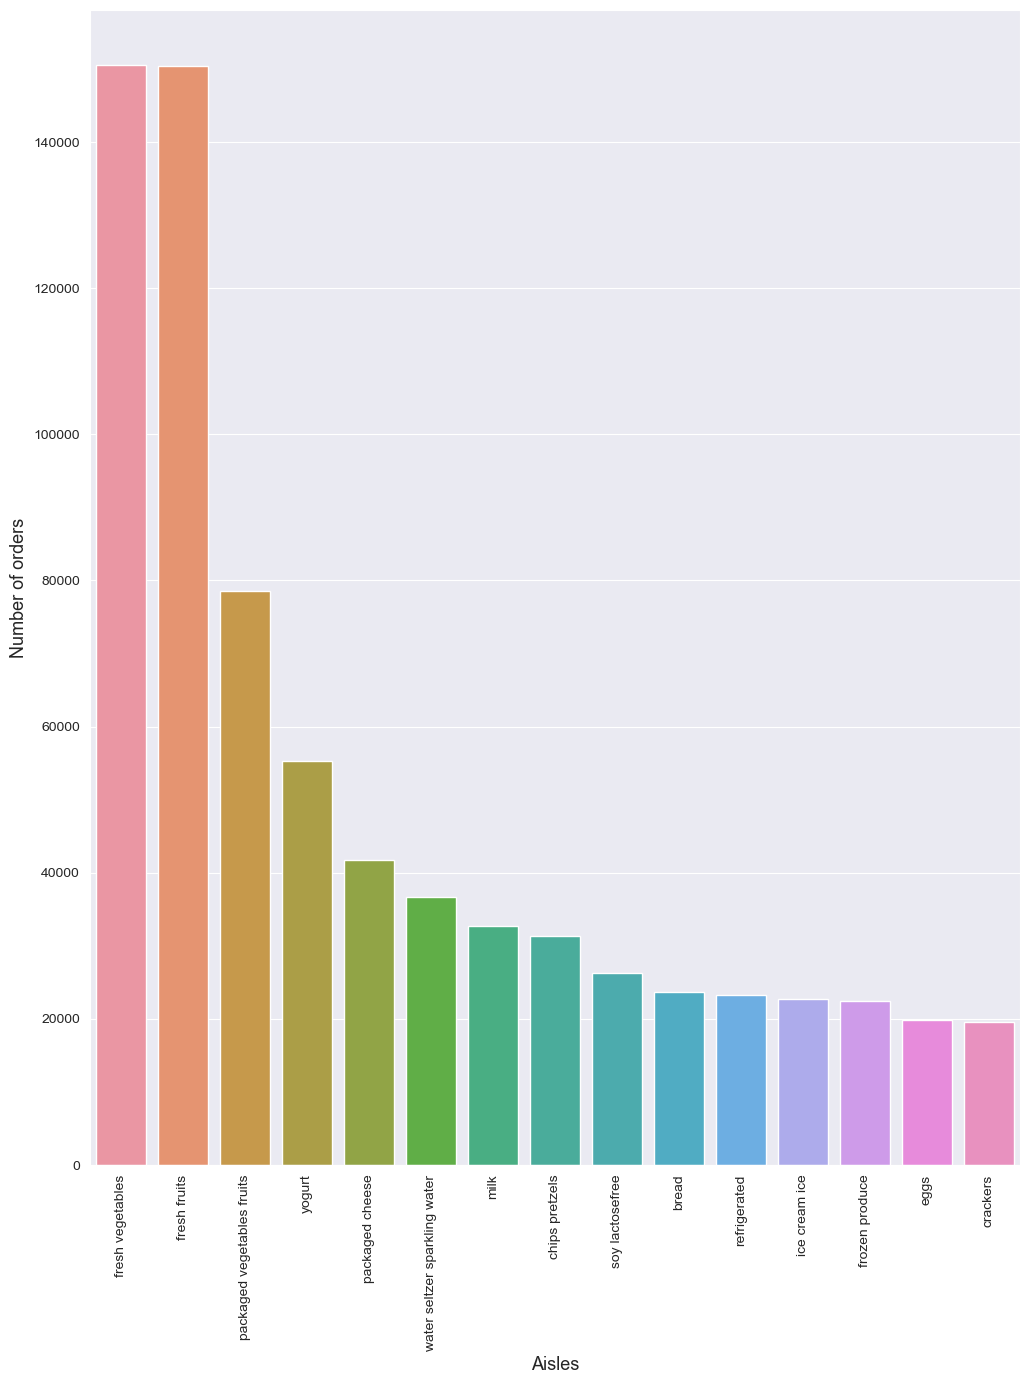

In [119]:
grouped = grouped.groupby(['aisle']).sum()['Total_orders'].sort_values(ascending=False)[:15]

f, ax = plt.subplots(figsize=(12,15))
plt.xticks(rotation='vertical')
sns.barplot(grouped.index, grouped.values)
plt.ylabel('Number of orders', fontsize=13)
plt.xlabel('Aisles', fontsize=13)
plt.show()

#### So we see that fresh vegetables and fresh fruits are the top 2 selling aisles, with each capturing 11% of all orders.

# Summary of our findings

- Customer ordering trends
    - Most orders are made between 9am and 4pm
    - The most common number of total orders across customers is 4
    - The most common number of products in an order is 5
    - 59% of all ordered products are reorders (were previously ordered by that customer)
    - The most common interval of time between an order and a reorder of that same product
        is either 1 week or 1 month


- The best selling departments (top 5)
    1. Produce
    2. Dairy & eggs
    3. Snacks
    4. Beverages
    5. Frozen
    
   
- The best selling aisles within each department (arbitrarily listing 5)
    - Bakery: bread
    - Alcohol: beer cooler
    - Beverages: tea
    - Canned goods: soup broth
    - Dairy & eggs: yogurt


- Aisles with the most products across all departments (top 5)
    1. Candy/chocolate
    2. Ice cream
    3. Vitamins/supplements
    4. Yogurt
    5. Chips
    

- The most ordered products (top 7)
    1. Bananas
    2. Strawberries
    3. Spinach
    4. Avocados
    5. Lemons
    6. Limes
    7. Milk
   

- The most reordered products (top 7)
    1. Serenity Overnight Pads
    2. Chocolate Love Bars
    3. Maca Buttercups
    4. Benchbreak Chardonnay
    5. Organic Blueberry B'Mega (drink)
    6. Fragrance Free Clay
    7. Thousand Island Salad Snax
 
